In [123]:
def preprocess_data(X):
    class CustomPreprocessor(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.scale = StandardScaler()
            self.enc = LabelEncoder()
            self.num_cols = None
            self.cat_cols = None

        def fit(self, X, y=None):
            self.num_cols = X.select_dtypes(include='float64').columns
            self.cat_cols = X.select_dtypes(include='object').columns
            return self

        def transform(self, X):
            X_transformed = X.copy()

            imputer = SimpleImputer(strategy="mean")
            X_transformed['bmi'] = imputer.fit_transform(X_transformed[['bmi']])

            for col in self.cat_cols:
                X_transformed[col] = self.enc.fit_transform(X_transformed[col])

            for col in self.num_cols:
                X_transformed[col] = self.scale.fit_transform(X_transformed[[col]])

            return X_transformed

    preprocessor = CustomPreprocessor()
    X_transformed = preprocessor.fit_transform(X)
    
    return X_transformed














import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn import metrics
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import mlflow
import utils
from sklearn.model_selection import train_test_split, StratifiedKFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator





from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



PATH = '/Users/mimi/Desktop/PYTHON/TURING/HOME/MachLearning/S2/data/archive (1).zip'

df = pd.read_csv(PATH)
df.drop(columns='id', inplace=True)
df_ = df.copy()
df.drop(df[df.gender == 'Other'].index,inplace=True)
df.reset_index(drop=True,inplace=True)





df.head()



,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [108]:

num_splits = 3
stratified_kfold = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

true_proportions = []
negative_proportions = []


for fold_idx, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    
    y_fold = y[test_index]
    
    
    num_true = np.sum(y_fold == 1)
    num_negative = np.sum(y_fold == 0)
    
    
    proportion_true = num_true / len(y_fold)
    proportion_negative = num_negative / len(y_fold)
    
    
    true_proportions.append(proportion_true)
    negative_proportions.append(proportion_negative)


print("Proportion of true (positive) samples in each fold:", true_proportions)
print("Proportion of negative samples in each fold:", negative_proportions)


Proportion of true (positive) samples in each fold: [0.04873752201996477, 0.04873752201996477, 0.04873752201996477]
Proportion of negative samples in each fold: [0.9512624779800353, 0.9512624779800353, 0.9512624779800353]


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


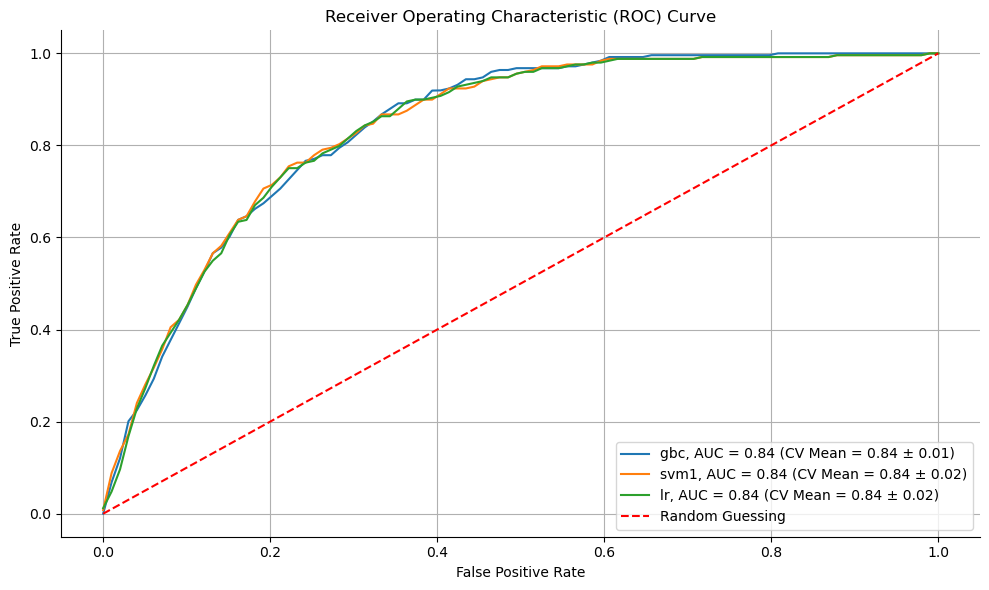

In [135]:
import operator

cv = 5
stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
X = df.drop(columns='stroke')
y = df['stroke']

clfs = {
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear', probability=True,class_weight='balanced'),
    'svm2': SVC(kernel='rbf', probability=True, class_weight='balanced'),
    'svm3': SVC(kernel='sigmoid', probability=True, class_weight='balanced'),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(class_weight='balanced'),
    'rfc': RandomForestClassifier(class_weight='balanced'),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression(class_weight='balanced')
}

models = {}  

mean_fpr = np.linspace(0, 1, 100)

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score

results_list = []
for clf_name, clf in clfs.items():
    fold_auc_scores = []
    fold_precision_scores = []
    fold_recall_scores = []
    fold_f1_scores = []
    tprs = []
    aucs = []
    conf_mats = []  

    for train_index, test_index in stratified_kfold.split(X, y):
        X_train, X_test = utils.preprocess_data(X.iloc[train_index]), utils.preprocess_data(X.iloc[test_index])
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        auc_score = roc_auc_score(y_test, y_pred_proba)
        fold_auc_scores.append(auc_score)
        
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        fold_precision_scores.append(precision_score(y_test, clf.predict(X_test)))
        fold_recall_scores.append(recall_score(y_test, clf.predict(X_test)))
        fold_f1_scores.append(f1_score(y_test, clf.predict(X_test)))
        
        y_pred = clf.predict(X_test)
        conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
        conf_mats.append(conf_mat)

    mean_auc_score = np.mean(fold_auc_scores)
    std_auc_score = np.std(fold_auc_scores)
    mean_tpr = np.mean(tprs, axis=0)
    mean_roc_auc = auc(mean_fpr, mean_tpr)
    mean_precision = np.mean(fold_precision_scores)
    mean_recall = np.mean(fold_recall_scores)
    mean_f1 = np.mean(fold_f1_scores)
    mean_conf_mat = np.mean(conf_mats, axis=0)  

    models[clf_name] = clf

    results_list.append({'Classifier': clf_name, 
                         'Mean AUC': mean_auc_score, 
                         'Std AUC': std_auc_score,
                         'Mean Precision': mean_precision,
                         'Mean Recall': mean_recall,
                         'Mean F1': mean_f1,
                         'Mean TPR': mean_tpr, 
                         'Mean ROC AUC': mean_roc_auc, 
                         'Mean Confusion Matrix': mean_conf_mat})

results_df = pd.DataFrame(results_list)

sorted_results_df = results_df.sort_values(by='Mean AUC', ascending=False)

top_3_models_df = sorted_results_df.head(3)

plt.figure(figsize=(10, 6))
for _, row in top_3_models_df.iterrows():
    clf_name = row['Classifier']
    mean_auc = row['Mean AUC']
    std_auc = row['Std AUC']
    mean_tpr = row['Mean TPR']
    mean_roc_auc = row['Mean ROC AUC']
    
    plt.plot(mean_fpr, mean_tpr, label=f"{clf_name}, AUC = {mean_roc_auc:.2f} (CV Mean = {mean_auc:.2f} ± {std_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
sns.despine()
plt.show()


In [137]:
top_3_models_df

,Classifier,Mean AUC,Std AUC,Mean Precision,Mean Recall,Mean F1,Mean TPR,Mean ROC AUC,Mean Confusion Matrix
7,gbc,0.838734,0.014411,0.120000,0.012082,0.021953,"[0.0, 0.06824489795918368, 0.12040816326530612...",0.838833,"[[968.8, 3.2], [49.2, 0.6]]"
1,svm1,0.838059,0.019796,0.129416,0.798776,0.222738,"[0.008, 0.08816326530612245, 0.136163265306122...",0.838236,"[[704.6, 267.4], [10.0, 39.8]]"
8,lr,0.836224,0.019752,0.132254,0.782776,0.226270,"[0.012, 0.04808163265306122, 0.096244897959183...",0.836203,"[[716.4, 255.6], [10.8, 39.0]]"


In [131]:

cv = 5
stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
X = df.drop(columns='stroke')
y = df['stroke']

clfs = {
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear', probability=True,class_weight='balanced'),
    'svm2': SVC(kernel='rbf', probability=True, class_weight='balanced'),
    'svm3': SVC(kernel='sigmoid', probability=True, class_weight='balanced'),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(class_weight='balanced'),
    'rfc': RandomForestClassifier(class_weight='balanced'),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression(class_weight='balanced')
}

models = {}  

mean_fpr = np.linspace(0, 1, 100)

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score

results_list = []

for clf_name, clf in clfs.items():
    fold_results = []  
    
    for fold_idx, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
        fold_result = {} 
        
        X_train, X_test = utils.preprocess_data(X.iloc[train_index]), utils.preprocess_data(X.iloc[test_index])
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        precision_avg = precision_score(y_test, clf.predict(X_test))
        recall_avg = recall_score(y_test, clf.predict(X_test))
        f1_avg = f1_score(y_test, clf.predict(X_test))
        
        y_pred = clf.predict(X_test)
        conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
        
        fold_result['Classifier'] = clf_name
        fold_result['Fold'] = fold_idx + 1
        fold_result['AUC'] = auc_score
        fold_result['Precision'] = precision_avg
        fold_result['Recall'] = recall_avg
        fold_result['F1'] = f1_avg
        fold_result['Confusion_Matrix'] = conf_mat
        
        fold_results.append(fold_result)
    
    results_list.extend(fold_results)

results_df = pd.DataFrame(results_list)


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


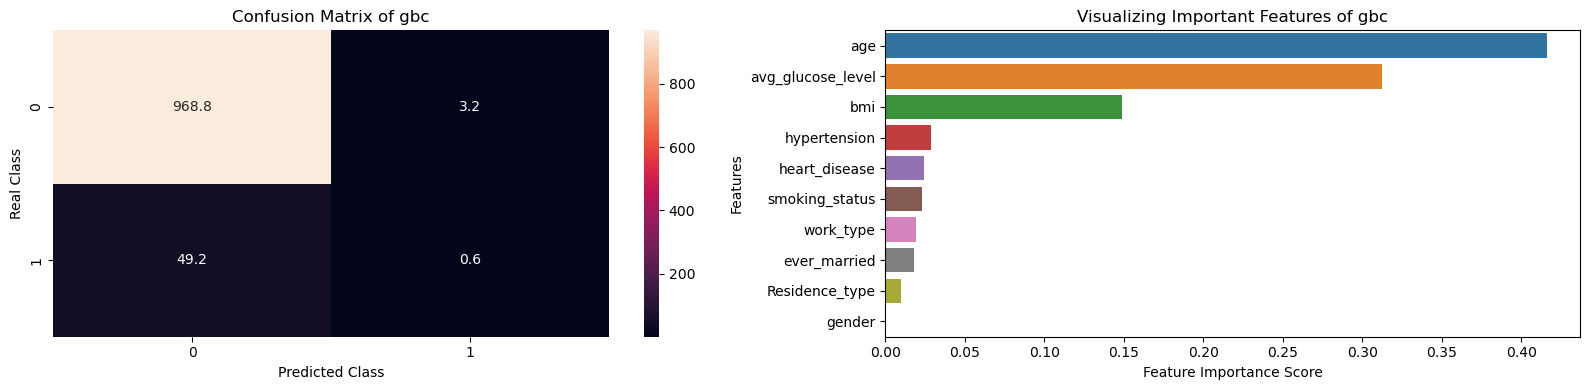

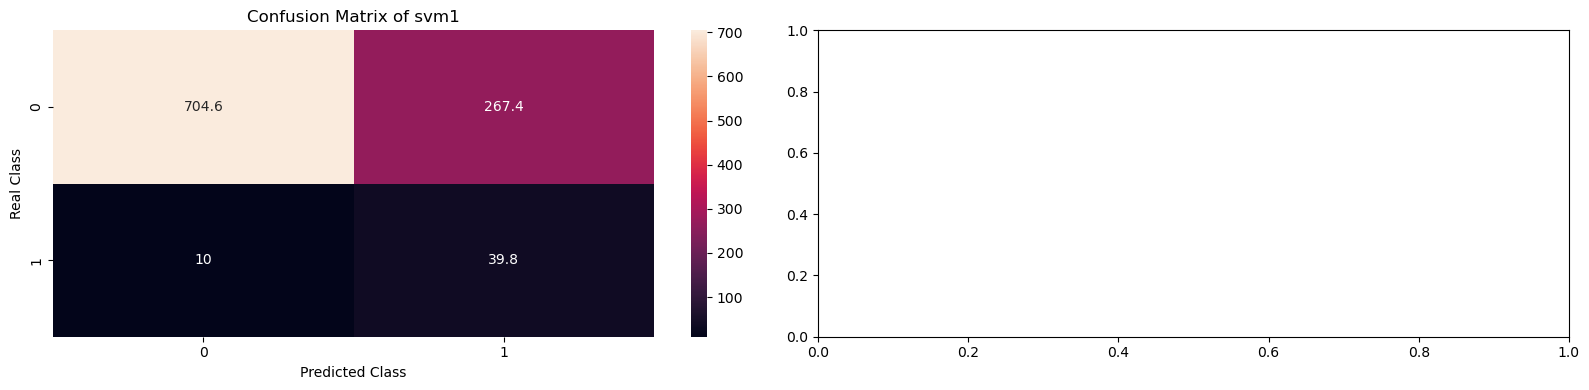

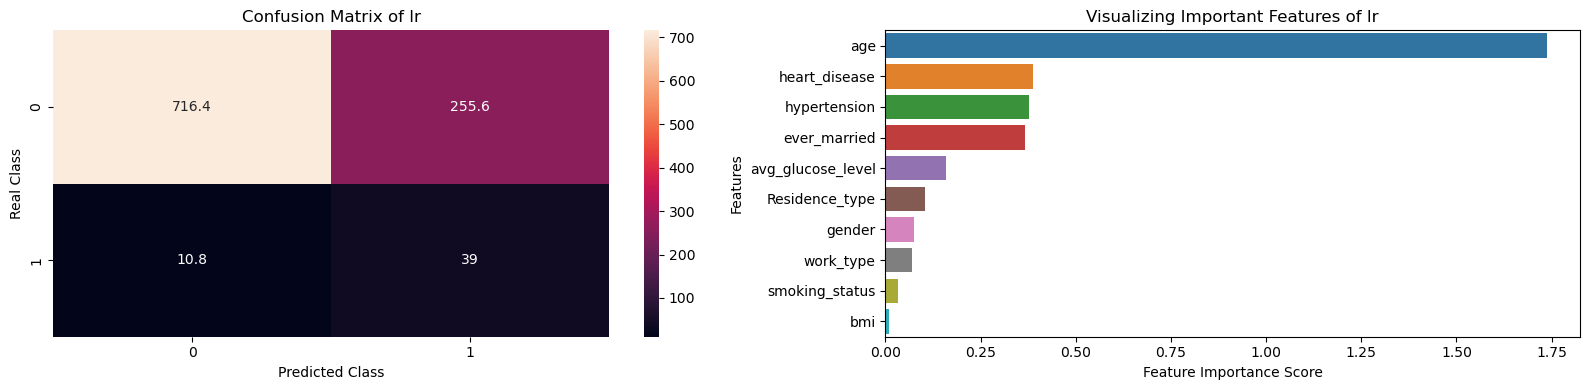

In [136]:
def plot_top_models(top_models_df, models, X_train):
    for _, row in top_models_df.iterrows():
        clf_name = row['Classifier']
        mean_conf_mat = row['Mean Confusion Matrix']

        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

        
        sns.heatmap(mean_conf_mat, annot=True, fmt='g', ax=axes[0])
        axes[0].set_title(f'Confusion Matrix of {clf_name}')
        axes[0].set_ylabel('Real Class')
        axes[0].set_xlabel('Predicted Class')

        
        clf_model = models[clf_name]
        if hasattr(clf_model, 'feature_importances_'):
            feature_importance = clf_model.feature_importances_
            feature_scores = pd.Series(feature_importance, index=X_train.columns).sort_values(ascending=False)
            sns.barplot(x=feature_scores, y=feature_scores.index, ax=axes[1])
            axes[1].set_xlabel('Feature Importance Score')
            axes[1].set_ylabel('Features')
            axes[1].set_title(f"Visualizing Important Features of {clf_name}")
        elif clf_name == 'lr':  
            coefficients = models['lr'].coef_[0]
            imp_df = pd.DataFrame({"Feature Name": X_train.columns, "Importance": np.abs(coefficients)})
            features = imp_df.sort_values(by="Importance", ascending=False)
            sns.barplot(x=features["Importance"], y=features["Feature Name"], ax=axes[1])
            axes[1].set_xlabel('Feature Importance Score')
            axes[1].set_ylabel('Features')
            axes[1].set_title(f"Visualizing Important Features of {clf_name}")

        plt.tight_layout()
        plt.show()


plot_top_models(top_3_models_df, models, X_train)

In [133]:
results_df

,Classifier,Fold,AUC,Precision,Recall,F1,Confusion_Matrix
0,gnb,1,0.804733,0.172131,0.420000,0.244186,"[[871, 101], [29, 21]]"
1,gnb,2,0.814074,0.130435,0.300000,0.181818,"[[872, 100], [35, 15]]"
2,gnb,3,0.801337,0.133333,0.360000,0.194595,"[[855, 117], [32, 18]]"
3,gnb,4,0.804136,0.185185,0.500000,0.270270,"[[862, 110], [25, 25]]"
4,gnb,5,0.823801,0.151261,0.367347,0.214286,"[[871, 101], [31, 18]]"
5,svm1,1,0.838909,0.127036,0.780000,0.218487,"[[704, 268], [11, 39]]"
6,svm1,2,0.827860,0.134426,0.820000,0.230986,"[[708, 264], [9, 41]]"
7,svm1,3,0.852881,0.133758,0.840000,0.230769,"[[700, 272], [8, 42]]"
8,svm1,4,0.863786,0.137380,0.860000,0.236915,"[[702, 270], [7, 43]]"
9,svm1,5,0.806857,0.114478,0.693878,0.196532,"[[709, 263], [15, 34]]"


{}

In [43]:
models['lr']

LogisticRegression()

In [47]:
top_3_models_df

,Classifier,Mean AUC,Std AUC,Mean TPR,Mean ROC AUC,Mean Confusion Matrix
7,gbc,0.838504,0.014545,"[0.0, 0.06424489795918367, 0.11640816326530612...",0.838532,"[[968.6, 3.4], [49.2, 0.6]]"
8,lr,0.837189,0.021146,"[0.012, 0.06416326530612246, 0.116244897959183...",0.837208,"[[971.8, 0.2], [49.8, 0.0]]"
4,ada,0.825906,0.015965,"[0.0, 0.052163265306122454, 0.1243265306122449...",0.825901,"[[970.2, 1.8], [49.2, 0.6]]"


In [29]:
top_3_models_df[top_3_models_df['Classifier'] == 'logr']['Mean AUC'].values[0]

0.8371894683799445

In [44]:
models

{'gnb': GaussianNB(),
 'svm1': SVC(kernel='linear', probability=True),
 'svm2': SVC(probability=True),
 'svm3': SVC(kernel='sigmoid', probability=True),
 'ada': AdaBoostClassifier(),
 'dtc': DecisionTreeClassifier(),
 'rfc': RandomForestClassifier(),
 'gbc': GradientBoostingClassifier(),
 'lr': LogisticRegression()}

In [17]:
models['logr'].coef_[0]

array([ 0.13815729,  1.6651662 ,  0.39719136,  0.34786705, -0.439341  ,
       -0.02487375,  0.11882414,  0.17064162, -0.05228088, -0.00639305])

In [69]:
def plot_top_models(top_models_df, models, X_train):
    for _, row in top_models_df.iterrows():
        clf_name = row['Classifier']
        mean_conf_mat = row['Mean Confusion Matrix']

        # Plotting side by side
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

        # Plot confusion matrix
        sns.heatmap(mean_conf_mat, annot=True, fmt='g', ax=axes[0])
        axes[0].set_title(f'Confusion Matrix of {clf_name}')
        axes[0].set_ylabel('Real Class')
        axes[0].set_xlabel('Predicted Class')

        # Plot feature importance
        clf_model = models[clf_name]
        if hasattr(clf_model, 'feature_importances_'):
            feature_importance = clf_model.feature_importances_
            feature_scores = pd.Series(feature_importance, index=X_train.columns).sort_values(ascending=False)
            sns.barplot(x=feature_scores, y=feature_scores.index, ax=axes[1])
            axes[1].set_xlabel('Feature Importance Score')
            axes[1].set_ylabel('Features')
            axes[1].set_title(f"Visualizing Important Features of {clf_name}")
        elif clf_name == 'lr':  # Logistic Regression
            coefficients = models['lr'].coef_[0]
            imp_df = pd.DataFrame({"Feature Name": X_train.columns, "Importance": np.abs(coefficients)})
            features = imp_df.sort_values(by="Importance", ascending=False)
            sns.barplot(x=features["Importance"], y=features["Feature Name"], ax=axes[1])
            axes[1].set_xlabel('Feature Importance Score')
            axes[1].set_ylabel('Features')
            axes[1].set_title(f"Visualizing Important Features of {clf_name}")

        plt.tight_layout()
        plt.show()

# Example usage
plot_top_models(top_3_models_df, models, X_train)


KeyError: 'Mean Confusion Matrix'

In [83]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Define preprocess_data as a transformer
def preprocess_data(X):
    class CustomPreprocessor(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.scale = StandardScaler()
            self.enc = LabelEncoder()
            self.num_cols = None
            self.cat_cols = None

        def fit(self, X, y=None):
            self.num_cols = X.select_dtypes(include='float64').columns
            self.cat_cols = X.select_dtypes(include='object').columns
            return self

        def transform(self, X):
            X_transformed = X.copy()

            imputer = SimpleImputer(strategy="mean")
            X_transformed['bmi'] = imputer.fit_transform(X_transformed[['bmi']])

            for col in self.cat_cols:
                X_transformed[col] = self.enc.fit_transform(X_transformed[col])

            for col in self.num_cols:
                X_transformed[col] = self.scale.fit_transform(X_transformed[[col]])

            return X_transformed

    preprocessor = CustomPreprocessor()
    X_transformed = preprocessor.fit_transform(X)
    
    return X_transformed

preprocess_data_transformer = FunctionTransformer(preprocess_data)

cv = 5
X = df.drop(columns='stroke')
y = df['stroke']

clfs = {
    #'gnb': GaussianNB(),
    #'svm1': SVC(kernel='linear', probability=True),
    #'svm2': SVC(kernel='rbf', probability=True),
    #'svm3': SVC(kernel='sigmoid', probability=True),
    'ada_boost': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

models = {}  # Dictionary to store trained models

mean_fpr = np.linspace(0, 1, 100)

results_list = []
for clf_name, clf in clfs.items():
    # Create a pipeline with preprocessing and the classifier
    pipeline = make_pipeline(preprocess_data_transformer, clf)
    
    # Perform cross-validation with the pipeline
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
    mean_auc_score = np.mean(scores)
    std_auc_score = np.std(scores)

    results_list.append({'Classifier': clf_name, 'Mean AUC': mean_auc_score, 'Std AUC': std_auc_score})

    # Train the model and store it in the models dictionary
    pipeline.fit(X, y)
    models[clf_name.lower()] = pipeline.named_steps[clf_name.lower()]



results_df = pd.DataFrame(results_list)

sorted_results_df = results_df.sort_values(by='Mean AUC', ascending=False)

top_3_models_df = sorted_results_df.head(3)

# Calculate mean confusion matrix for each classifier and add it to the DataFrame
for index, row in top_3_models_df.iterrows():
    clf_name = row['Classifier']
    clf_model = models[clf_name]
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    conf_mats = []
    for train_index, test_index in stratified_kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline = make_pipeline(preprocess_data_transformer, clf_model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        conf_mat = confusion_matrix(y_test, y_pred)
        conf_mats.append(conf_mat)

    mean_conf_mat = np.mean(conf_mats, axis=0)
    top_3_models_df.at[index, 'Mean Confusion Matrix'] = mean_conf_mat

def plot_top_models(top_models_df, models, X_train):
    for _, row in top_models_df.iterrows():
        clf_name = row['Classifier']
        mean_conf_mat = row['Mean Confusion Matrix']

        # Plotting side by side
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

        # Plot confusion matrix
        sns.heatmap(mean_conf_mat, annot=True, fmt='g', ax=axes[0])
        axes[0].set_title(f'Confusion Matrix of {clf_name}')
        axes[0].set_ylabel('Real Class')
        axes[0].set_xlabel('Predicted Class')

        # Plot feature importance
        clf_model = models[clf_name]
        if hasattr(clf_model, 'feature_importances_'):
            feature_importance = clf_model.feature_importances_
            feature_scores = pd.Series(feature_importance, index=X_train.columns).sort_values(ascending=False)
            sns.barplot(x=feature_scores, y=feature_scores.index, ax=axes[1])
            axes[1].set_xlabel('Feature Importance Score')
            axes[1].set_ylabel('Features')
            axes[1].set_title(f"Visualizing Important Features of {clf_name}")
        elif clf_name == 'lr':  # Logistic Regression
            coefficients = models['lr'].coef_[0]
            imp_df = pd.DataFrame({"Feature Name": X_train.columns, "Importance": np.abs(coefficients)})
            features = imp_df.sort_values(by="Importance", ascending=False)
            sns.barplot(x=features["Importance"], y=features["Feature Name"], ax=axes[1])
            axes[1].set_xlabel('Feature Importance Score')
            axes[1].set_ylabel('Features')
            axes[1].set_title(f"Visualizing Important Features of {clf_name}")

        plt.tight_layout()
        plt.show()

# Example usage
plot_top_models(top_3_models_df, models, X_train)


KeyError: 'ada_boost'

In [84]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Define preprocess_data as a transformer
def preprocess_data(X):
    class CustomPreprocessor(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.scale = StandardScaler()
            self.enc = LabelEncoder()
            self.num_cols = None
            self.cat_cols = None

        def fit(self, X, y=None):
            self.num_cols = X.select_dtypes(include='float64').columns
            self.cat_cols = X.select_dtypes(include='object').columns
            return self

        def transform(self, X):
            X_transformed = X.copy()

            imputer = SimpleImputer(strategy="mean")
            X_transformed['bmi'] = imputer.fit_transform(X_transformed[['bmi']])

            for col in self.cat_cols:
                X_transformed[col] = self.enc.fit_transform(X_transformed[col])

            for col in self.num_cols:
                X_transformed[col] = self.scale.fit_transform(X_transformed[[col]])

            return X_transformed

    preprocessor = CustomPreprocessor()
    X_transformed = preprocessor.fit_transform(X)
    
    return X_transformed

preprocess_data_transformer = FunctionTransformer(preprocess_data)

cv = 5
X = df.drop(columns='stroke')
y = df['stroke']

clfs = {
    #'gnb': GaussianNB(),
    #'svm1': SVC(kernel='linear', probability=True),
    #'svm2': SVC(kernel='rbf', probability=True),
    #'svm3': SVC(kernel='sigmoid', probability=True),
    'ada_boost': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

models = {}  # Dictionary to store trained models

mean_fpr = np.linspace(0, 1, 100)

results_list = []
for clf_name, clf in clfs.items():
    # Create a pipeline with preprocessing and the classifier
    pipeline = make_pipeline(preprocess_data_transformer, clf)
    
    # Perform cross-validation with the pipeline
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
    mean_auc_score = np.mean(scores)
    std_auc_score = np.std(scores)

    results_list.append({'Classifier': clf_name, 'Mean AUC': mean_auc_score, 'Std AUC': std_auc_score})

    # Train the model and store it in the models dictionary
    pipeline.fit(X, y)
    models[clf_name.lower()] = pipeline.named_steps[clf_name.lower()]



results_df = pd.DataFrame(results_list)

sorted_results_df = results_df.sort_values(by='Mean AUC', ascending=False)

top_3_models_df = sorted_results_df.head(3)

KeyError: 'ada_boost'

In [93]:
for clf_name, clf in clfs.items():
    # Create a pipeline with preprocessing and the classifier
    pipeline = make_pipeline(preprocess_data_transformer, clf)
    
    # Perform cross-validation with the pipeline
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
    mean_auc_score = np.mean(scores)
    std_auc_score = np.std(scores)

    results_list.append({'Classifier': clf_name, 'Mean AUC': mean_auc_score, 'Std AUC': std_auc_score})

    # Train the model and store it in the models dictionary
    pipeline.fit(X, y)
    models[clf_name] = pipeline.named_steps[clf_name]

KeyError: 'ada_boost'

In [99]:
clfs = AdaBoostClassifier()
pipeline = make_pipeline(preprocess_data_transformer, clfs)
pipeline.fit(X, y)
models[clf_name] = pipeline.named_steps[clf_name]


KeyError: 'lr'

In [100]:
pipeline.named_steps

{'functiontransformer': FunctionTransformer(func=<function preprocess_data at 0x14295ef20>),
 'adaboostclassifier': AdaBoostClassifier()}

In [95]:
models

{'ada_boost': 'ada_boost',
 'dtc': 'dtc',
 'rfc': 'rfc',
 'gbc': 'gbc',
 'lr': 'lr'}

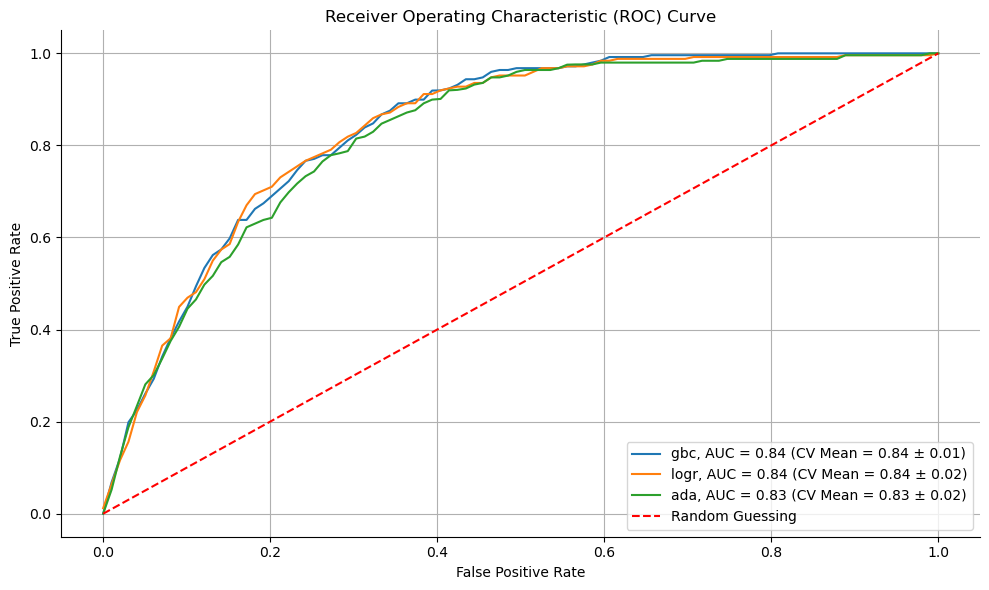

In [ ]:
import operator

cv = 5
stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
X = df.drop(columns='stroke')
y = df['stroke']

clfs = {
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear', probability=True),
    'svm2': SVC(kernel='rbf', probability=True),
    'svm3': SVC(kernel='sigmoid', probability=True),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'logr': LogisticRegression()
}

mean_fpr = np.linspace(0, 1, 100)

results_list = []
for clf_name, clf in clfs.items():
    fold_auc_scores = []
    tprs = []
    aucs = []

    for train_index, test_index in stratified_kfold.split(X, y):
        X_train, X_test = utils.preprocess_data(X.iloc[train_index]), utils.preprocess_data(X.iloc[test_index])
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        auc_score = roc_auc_score(y_test, y_pred_proba)
        fold_auc_scores.append(auc_score)

    mean_auc_score = np.mean(fold_auc_scores)
    std_auc_score = np.std(fold_auc_scores)
    mean_tpr = np.mean(tprs, axis=0)
    mean_roc_auc = auc(mean_fpr, mean_tpr)

    results_list.append({'Classifier': clf_name, 'Mean AUC': mean_auc_score, 'Std AUC': std_auc_score,
                         'Mean TPR': mean_tpr, 'Mean ROC AUC': mean_roc_auc})

results_df = pd.DataFrame(results_list)

sorted_results_df = results_df.sort_values(by='Mean AUC', ascending=False)

top_3_models_df = sorted_results_df.head(3)

plt.figure(figsize=(10, 6))
for _, row in top_3_models_df.iterrows():
    clf_name = row['Classifier']
    mean_auc = row['Mean AUC']
    std_auc = row['Std AUC']
    mean_tpr = row['Mean TPR']
    mean_roc_auc = row['Mean ROC AUC']
    
    plt.plot(mean_fpr, mean_tpr, label=f"{clf_name}, AUC = {mean_roc_auc:.2f} (CV Mean = {mean_auc:.2f} ± {std_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
sns.despine()
plt.show()


In [5]:


def plot_confusion_matrix_and_features(conf_mat, feature_importances, title=''):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    # Plot confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='g', ax=axes[0])
    axes[0].set_title(f'{title} Confusion Matrix', fontsize=14)
    axes[0].set_ylabel('Real Class', fontsize=12)
    axes[0].set_xlabel('Predicted Class', fontsize=12)

    # Plot feature importances
    feature_scores = pd.Series(feature_importances, index=feature_importances.index).sort_values(ascending=False)
    sns.barplot(x=feature_scores, y=feature_scores.index, ax=axes[1])
    axes[1].set_xlabel('Feature Importance Score')
    axes[1].set_ylabel('Features')
    axes[1].set_title(f"Visualizing Important Features for {title}")

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_confusion_matrix_and_features(conf_mat, feature_scores, title='Random Forest Classifier')
